### Training an Agent to solve the openAI gym's mountain car problem.

1. [Environment Details](https://github.com/openai/gym/wiki/MountainCar-v0)
2. [Leaderboard Page](https://github.com/openai/gym/wiki/Leaderboard#mountaincar-v0)

#### Mountain Car Problem: Get an under powered car to the top of a hill (top = 0.5 position)
1. Action Space: motor = (left, neutral, right):int
2. Observation Space: np.array([position, velocity])
    - Veclocity = (-0.07, 0.07)
    - Position = (-1.2, 0.6)

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep
import time
from scipy.special import softmax

env = gym.make('MountainCar-v0')

In [2]:
print(env.action_space)
print(env.observation_space)

Discrete(3)
Box(2,)


### Agent Class

In [3]:
class State:
    def __init__(self):
        self.pos = None
        self.vel = None

class Agent:
    def __init__(self, env):
        self.velocityLimit = np.array([env.observation_space.low[1], env.observation_space.high[1]])
        self.positionLimit = np.array([env.observation_space.low[0], env.observation_space.high[0]])
        self.velocityStep, self.positionStep = 0.005, 0.1
        self.velocitySpace = np.arange(self.velocityLimit[0], self.velocityLimit[1] 
                                       + self.velocityStep, self.velocityStep)
        self.positionSpace = np.arange(self.positionLimit[0], self.positionLimit[1] 
                                       + self.positionStep, self.positionStep)
        self.m, self.n, self.n_action = len(self.velocitySpace), len(self.positionSpace), 3
        self.Q = np.full(shape = (self.m, self.n, 3),
                                       fill_value = 0.0, dtype = np.float32)
        self.collectiveRecord = []
        self.success = []
        
    def getActionValueIndex(self, state):
        posOffset = state[0] - self.positionLimit[0]
        velOffset = state[1] - self.velocityLimit[0]
        posInd = posOffset // self.positionStep
        velInd = velOffset // self.velocityStep
        
        return np.array([velInd, posInd], dtype= np.int)
  
    def getAction(self, state):
        ind = self.getActionValueIndex(state, 0)
        p = self.Policy[ind[0], ind[1], :]
        action = np.random.choice([0, 1, 2], size = 1, p = p)
        return action[0]

In [4]:
env = gym.make('MountainCar-v0')
agent = Agent(env)
env.seed(0)
print("Q Shape = ",agent.Q.shape)

Q Shape =  (30, 20, 3)


## Training: SARSA($\lambda$) Agent

### Method: 
1. Sarsa($\lambda$) with $\lambda$ = 0.9.
2. States are represeted by discretiziing the position and velocity. 
2. epsilon-greedy policy with starting epsilon = 0.8 and decay rate = 0.995. epsilon is reset to 0.01 if it goes below 0.009.
3. starting learning-rate(alpha) = 0.8 and decay rate = 0.999. epsilon is reset to 0.01 if it goes below 0.005.
4. No reward shaping.

#### Goal: 
- Solving the problem means average reward of -110 or more for 100 consecutive iterations.

In [5]:
eps = 0.8
changed_eps= []
changes_alpha= []
alpha = 0.2
LAMBDA = 0.8
alphaDecay = 0.999
epsDecay = 0.995
agent.e = np.zeros(shape = (agent.m, agent.n, 3))
Finish = False
numEpisodeToSolve = -1
for i_eps in tqdm(range(1, 7001)):
    if Finish: break
    state = env.reset()
    gamma = 1.0
    ind = agent.getActionValueIndex(state)
    if np.random.random() < 1 - eps:
        action = np.argmax(agent.Q[ind[0], ind[1], :]) 
    else:
        action = np.random.randint(0, 3)
    
    for t in range(201):
        ind = agent.getActionValueIndex(state)
        nextState, reward, done, info = env.step(action)
        nextInd = agent.getActionValueIndex(nextState)
        
        if np.random.random() < 1 - eps:
            nextAction = np.argmax(agent.Q[nextInd[0], nextInd[1], :]) 
        else: 
            nextAction = np.random.randint(0, 3)
    
        delta = reward + gamma * agent.Q[nextInd[0],nextInd[1],nextAction] - agent.Q[ind[0],ind[1],action]
        agent.e[ind[0],ind[1],action] += 1
 
        agent.Q = np.add(agent.Q, np.multiply(alpha * delta, agent.e))
        agent.e = np.multiply(gamma * LAMBDA, agent.e)
        
        if done: 
            if t < 199:
                agent.success.append((i_eps, t))
            agent.collectiveRecord.append(-t)
            eps = max(0.0, eps * epsDecay)
            alpha = max(0.0, alpha * alphaDecay)
            if eps < 0.009 and i_eps < 4000:
                eps = 0.01
                changed_eps.append(i_eps)
            if alpha < 0.005 and i_eps < 4000:
                alpha = 0.01
                changes_alpha.append(i_eps)
            break
        state = nextState
        action = nextAction
# env.close()

100%|██████████| 7000/7000 [01:10<00:00, 98.60it/s] 


In [6]:
print(changed_eps)
print(changes_alpha)

[896, 918, 940, 962, 984, 1006, 1028, 1050, 1072, 1094, 1116, 1138, 1160, 1182, 1204, 1226, 1248, 1270, 1292, 1314, 1336, 1358, 1380, 1402, 1424, 1446, 1468, 1490, 1512, 1534, 1556, 1578, 1600, 1622, 1644, 1666, 1688, 1710, 1732, 1754, 1776, 1798, 1820, 1842, 1864, 1886, 1908, 1930, 1952, 1974, 1996, 2018, 2040, 2062, 2084, 2106, 2128, 2150, 2172, 2194, 2216, 2238, 2260, 2282, 2304, 2326, 2348, 2370, 2392, 2414, 2436, 2458, 2480, 2502, 2524, 2546, 2568, 2590, 2612, 2634, 2656, 2678, 2700, 2722, 2744, 2766, 2788, 2810, 2832, 2854, 2876, 2898, 2920, 2942, 2964, 2986, 3008, 3030, 3052, 3074, 3096, 3118, 3140, 3162, 3184, 3206, 3228, 3250, 3272, 3294, 3316, 3338, 3360, 3382, 3404, 3426, 3448, 3470, 3492, 3514, 3536, 3558, 3580, 3602, 3624, 3646, 3668, 3690, 3712, 3734, 3756, 3778, 3800, 3822, 3844, 3866, 3888, 3910, 3932, 3954, 3976, 3998]
[3688]


1. Print **reward** over 100 previous episodes for all the episodes during training

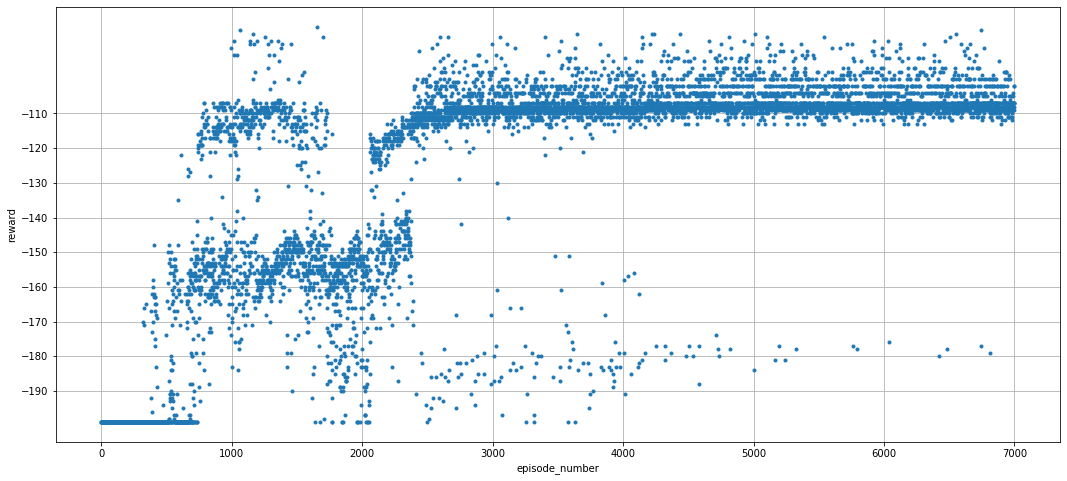

In [7]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(agent.collectiveRecord[:],'.')
plt.yticks(range(-110, -200, -10))
plt.ylabel("reward")
plt.xlabel("episode_number")
plt.grid()
plt.show()

2. Print **average reward** over 100 previous episodes for all the episodes during training

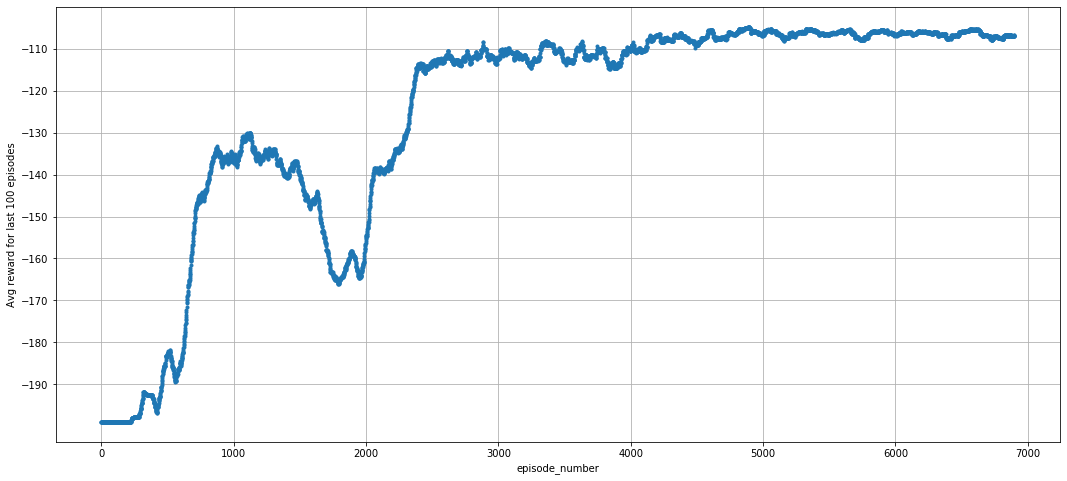

In [8]:
avgReward = []
for i in range(100, 7000):
    avgReward.append(np.mean(agent.collectiveRecord[i - 100:i]))
fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(avgReward, '.')
plt.yticks(range(-110, -200, -10))
# plt.xticks(changed_eps)
plt.ylabel("Avg reward for last 100 episodes")
plt.xlabel("episode_number")
plt.grid()
plt.show()

## Test Over 100 episodes

In [14]:
for i_eps in (range(1, 10)):
    state = env.reset()
    gamma = 1.0
    ind = agent.getActionValueIndex(state)
    action = np.argmax(agent.Q[ind[0], ind[1], :]) 
    
    for t in range(201):
        env.render()
        ind = agent.getActionValueIndex(state)
        nextState, reward, done, info = env.step(action)
        nextInd = agent.getActionValueIndex(nextState)
        
        nextAction = np.argmax(agent.Q[nextInd[0], nextInd[1], :])
        
        if done: 
            if t < 199:
                agent.success.append((i_eps, t))
            agent.collectiveRecord.append(-t)
            sleep(1)
            break
        state = nextState
        action = nextAction
env.close()

Average Reward on 100 training episodes = -107.33


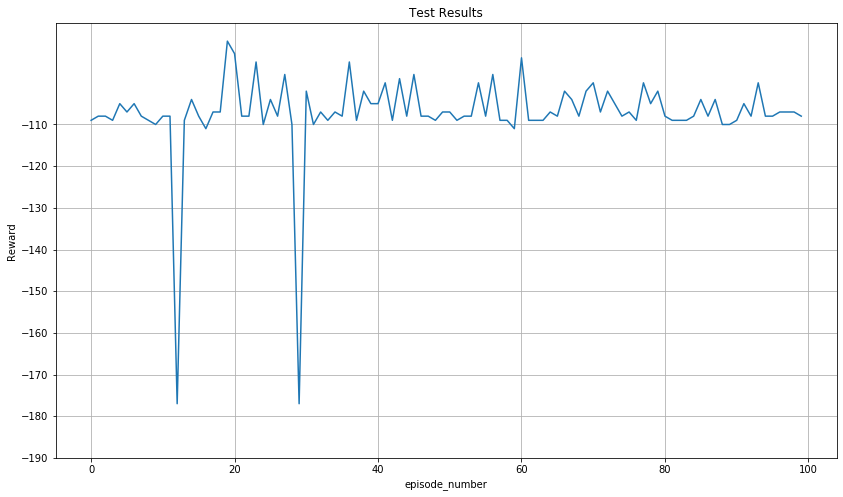

In [12]:
print("Average Reward on 100 training episodes = {}".format(np.mean(agent.collectiveRecord[-100:])))
fig, ax = plt.subplots(figsize = (14, 8))
plt.plot(agent.collectiveRecord[-100:], '-')
plt.yticks(range(-110, -200, -10))
plt.title("Test Results")
plt.ylabel("Reward")
plt.xlabel("episode_number")
plt.grid()
plt.show()